# **Library and Module Imports**

In [5]:
import torch
print("CUDA Available:", torch.cuda.is_available())
print("GPU Count:", torch.cuda.device_count())
print("GPU Name:", (torch.cuda.get_device_name(0) if torch.cuda.device_count() > 0 else ""))

CUDA Available: True
GPU Count: 1
GPU Name: NVIDIA GeForce RTX 3050 Ti Laptop GPU


In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


In [7]:
# Step 1: Imports & Setup
import os
import librosa
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt


# **Load Audio Data**

In [8]:
# Step 2: Load file paths and extract labels
def parse_filename(filename):
    parts = filename.split('_')
    emotion = parts[2]  # DIS, HAP, etc.
    emotion_map = {
        'ANG': 'angry',
        'DIS': 'disgust',
        'FEA': 'fear',
        'HAP': 'happy',
        'NEU': 'neutral',
        'SAD': 'sad'
    }
    return emotion_map.get(emotion, 'unknown')

# crema_path points to folder with audio
crema_path = "audio-emotion-dataset"
data = []

for file in os.listdir(crema_path):
    if file.endswith(".wav"):
        emotion = parse_filename(file)
        path = os.path.join(crema_path, file)
        data.append((path, emotion))

df = pd.DataFrame(data, columns=["file", "emotion"])


# **EDA (Exploratory Data Analysis)**

C:\Users\Asus\AppData\Local\Temp\ipykernel_6252\2421449884.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='emotion', order=df['emotion'].value_counts().index, palette='viridis')


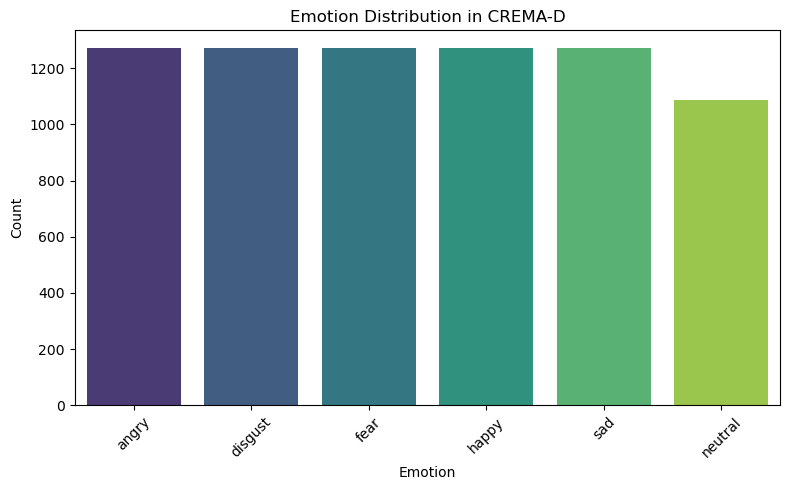

In [9]:
plt.figure(figsize=(8, 5))
sns.countplot(data=df, x='emotion', order=df['emotion'].value_counts().index, palette='viridis')
plt.title("Emotion Distribution in CREMA-D")
plt.xlabel("Emotion")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# **Audio Duration Distribution**

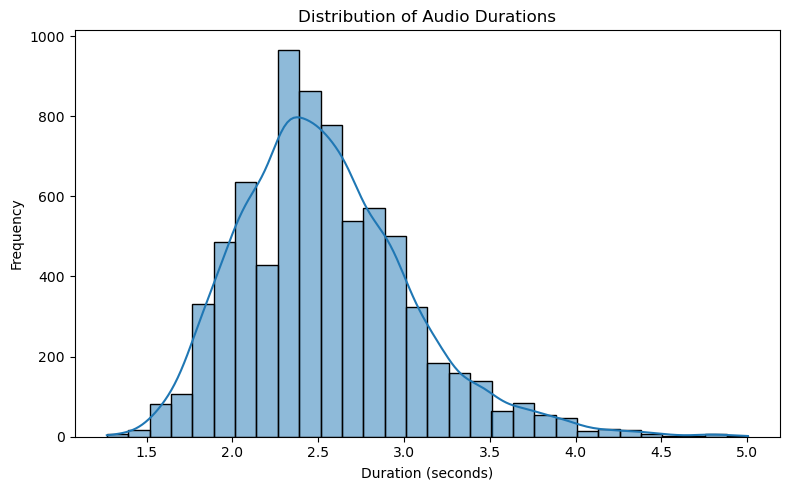

In [10]:
durations = []

for path in df['file']:
    y, sr = librosa.load(path)
    durations.append(librosa.get_duration(y=y, sr=sr))

df['duration'] = durations

plt.figure(figsize=(8, 5))
sns.histplot(df['duration'], bins=30, kde=True)
plt.title("Distribution of Audio Durations")
plt.xlabel("Duration (seconds)")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()


# **Average Duration per Emotion**

C:\Users\Asus\AppData\Local\Temp\ipykernel_6252\417352958.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='emotion', y='duration', palette='coolwarm')


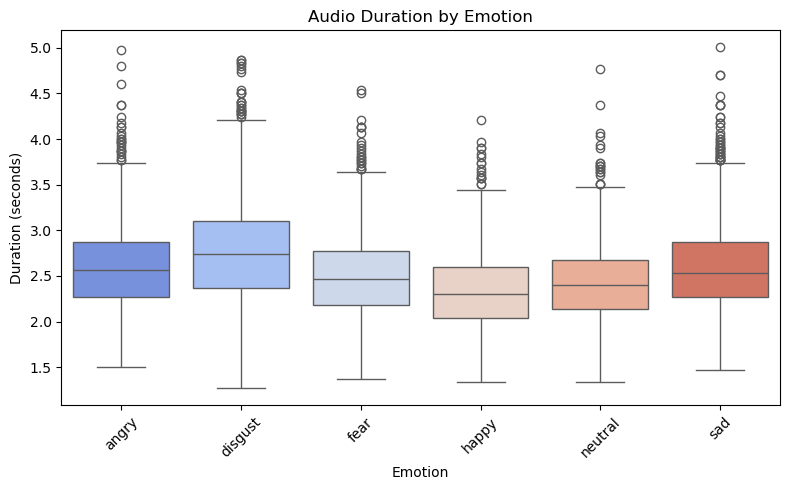

In [11]:
plt.figure(figsize=(8, 5))
sns.boxplot(data=df, x='emotion', y='duration', palette='coolwarm')
plt.title("Audio Duration by Emotion")
plt.xlabel("Emotion")
plt.ylabel("Duration (seconds)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# **Data Preprocessing**

In [12]:
# preprocessing audio files to make them uniform

# Constants
SAMPLE_RATE = 16000
DURATION = 3  # seconds
SAMPLES_PER_CLIP = SAMPLE_RATE * DURATION

def preprocess_audio(file_path):
    y, _ = librosa.load(file_path, sr=SAMPLE_RATE)
    y = librosa.util.normalize(y)

    if len(y) < SAMPLES_PER_CLIP:
        y = np.pad(y, (0, SAMPLES_PER_CLIP - len(y)))
    else:
        y = y[:SAMPLES_PER_CLIP]

    return y

# Apply preprocessing
preprocessed_audio = []
labels = []

for i in tqdm(range(len(df))):
    file_path = df.loc[i, "file"]
    emotion = df.loc[i, "emotion"]
    try:
        audio = preprocess_audio(file_path)
        preprocessed_audio.append(audio)
        labels.append(emotion)
    except Exception as e:
        print(f"Error processing {file_path}: {e}")

100%|██████████| 7442/7442 [00:04<00:00, 1689.24it/s]


# **Feature extraction**

In [13]:
# Step 3: Feature Extraction
def extract_features(file_path):
    y, sr = librosa.load(file_path, sr=None)
    
    mfcc = np.mean(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13).T, axis=0) #MFCC (Mel-frequency cepstral coefficients) – captures timbral texture.
    chroma = np.mean(librosa.feature.chroma_stft(y=y, sr=sr).T, axis=0) #Chroma – reflects pitch class energy (musical notes).
    contrast = np.mean(librosa.feature.spectral_contrast(y=y, sr=sr).T, axis=0) #Spectral Contrast – helps with timbre and brightness.
    zcr = np.mean(librosa.feature.zero_crossing_rate(y).T, axis=0) #ZCR (Zero Crossing Rate) – good for detecting noisiness or fricatives.
    rms = np.mean(librosa.feature.rms(y=y).T, axis=0) #RMS (Root Mean Square Energy) – correlates with loudness.

    return np.hstack([mfcc, chroma, contrast, zcr, rms])


In [14]:
# Extract features for each audio file
X = []
y = []

for i, row in tqdm(df.iterrows(), total=len(df)):
    try:
        features = extract_features(row["file"])
        X.append(features)
        y.append(row["emotion"])
    except Exception as e:
        print(f"Failed for {row['file']} - {str(e)}")

X = np.array(X)
y = np.array(y)


 83%|████████▎ | 6181/7442 [01:44<00:20, 61.63it/s]c:\Users\Asus\anaconda3\envs\my_env\Lib\site-packages\librosa\core\pitch.py:103: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(
100%|██████████| 7442/7442 [02:05<00:00, 59.35it/s]


In [15]:
import numpy as np
unique, counts = np.unique(y, return_counts=True)
label_counts = dict(zip(unique, counts))
print(label_counts)

{'angry': 1271, 'disgust': 1271, 'fear': 1271, 'happy': 1271, 'neutral': 1087, 'sad': 1271}


# **Train/Test Split**

In [16]:
# Step 4: Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

# **LabelEncoder**

In [25]:
from sklearn.preprocessing import LabelEncoder
import joblib

le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)  # For training data
y_test_encoded = le.transform(y_test)  # For test data

# save tesing data
np.save("SVM/X_test.npy", X_test)
np.save("SVM/y_test.npy", y_test_encoded)

# Save the fitted LabelEncoder
joblib.dump(le, "SVM/label_encoder.joblib")

['SVM/label_encoder.joblib']

# **SVM Model**

In [26]:
import os
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import GridSearchCV

# Folder and model path
model_dir = "SVM"
model_path = os.path.join(model_dir, "svm_model.joblib")

# Ensure the folder exists
os.makedirs(model_dir, exist_ok=True)

if os.path.exists(model_path):
    # Load model
    print("Loaded saved SVM model.")
    best_svc = joblib.load(model_path)
    y_pred = best_svc.predict(X_test)

    # Evaluate
    accuracy = accuracy_score(y_test_encoded, y_pred)
    print(f"Accuracy of Loaded Model: {accuracy * 100:.2f}%")
    print("\nClassification Report:\n", classification_report(y_test_encoded, y_pred, target_names=le.classes_))

else:
    # Define parameter grid
    param_grid = {
        'C': [0.01, 0.1, 1, 10, 100],
        'kernel': ['linear', 'rbf']
    }

    # Grid Search
    svc = SVC()
    grid_search = GridSearchCV(svc, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
    grid_search.fit(X_train, y_train_encoded)

    # Best model
    best_svc = grid_search.best_estimator_
    joblib.dump(best_svc, model_path)
    print("Trained and saved new SVM model.")

    y_pred = best_svc.predict(X_test)
    accuracy = accuracy_score(y_test_encoded, y_pred)
    print(f"Accuracy of Trained Model: {accuracy * 100:.2f}%")
    print("\nClassification Report:\n", classification_report(y_test_encoded, y_pred, target_names=le.classes_))

    # Plot Grid Search Results
    results_df = pd.DataFrame(grid_search.cv_results_)
    pivot_table = results_df.pivot_table(
        values='mean_test_score',
        index='param_C',
        columns='param_kernel'
    )

    plt.figure(figsize=(8, 6))
    sns.heatmap(pivot_table, annot=True, fmt=".3f", cmap="YlGnBu")
    plt.title("SVM Accuracy - Grid Search Results")
    plt.xlabel("Kernel")
    plt.ylabel("C")
    plt.show()


Loaded saved SVM model.
Accuracy of Loaded Model: 44.53%

Classification Report:
               precision    recall  f1-score   support

       angry       0.60      0.67      0.63       255
     disgust       0.36      0.35      0.36       254
        fear       0.35      0.29      0.32       254
       happy       0.40      0.34      0.37       254
     neutral       0.43      0.36      0.39       218
         sad       0.48      0.64      0.55       254

    accuracy                           0.45      1489
   macro avg       0.44      0.44      0.44      1489
weighted avg       0.44      0.45      0.44      1489



In [27]:
from sklearn.metrics import classification_report
import json

# Get classification report as dictionary
report = classification_report(y_test_encoded, y_pred, target_names=le.classes_, output_dict=True)

# Compute results
svm_results = {
    "accuracy": accuracy * 100,
    "precision_macro": report["macro avg"]["precision"] * 100,
    "recall_macro": report["macro avg"]["recall"] * 100,
    "f1_macro": report["macro avg"]["f1-score"] * 100
}

# Path to shared JSON file
json_path = "evaluation_results.json"

# Load existing JSON or create new dict
if os.path.exists(json_path):
    with open(json_path, "r") as f:
        all_results = json.load(f)
else:
    all_results = {}

# Update SVM section
all_results["svm"] = svm_results

# Save back to JSON
with open(json_path, "w") as f:
    json.dump(all_results, f, indent=4)

print(f"Saved SVM evaluation under key 'svm' in {json_path}")


Saved SVM evaluation under key 'svm' in evaluation_results.json


# **Random Forest Model**

✅ Loaded saved Random Forest model.

Accuracy: 48.56%

Classification Report:
              precision    recall  f1-score   support

       angry       0.60      0.75      0.66       255
     disgust       0.45      0.35      0.39       254
        fear       0.45      0.19      0.27       254
       happy       0.41      0.42      0.41       254
     neutral       0.44      0.56      0.49       218
         sad       0.51      0.67      0.58       254

    accuracy                           0.49      1489
   macro avg       0.48      0.49      0.47      1489
weighted avg       0.48      0.49      0.47      1489



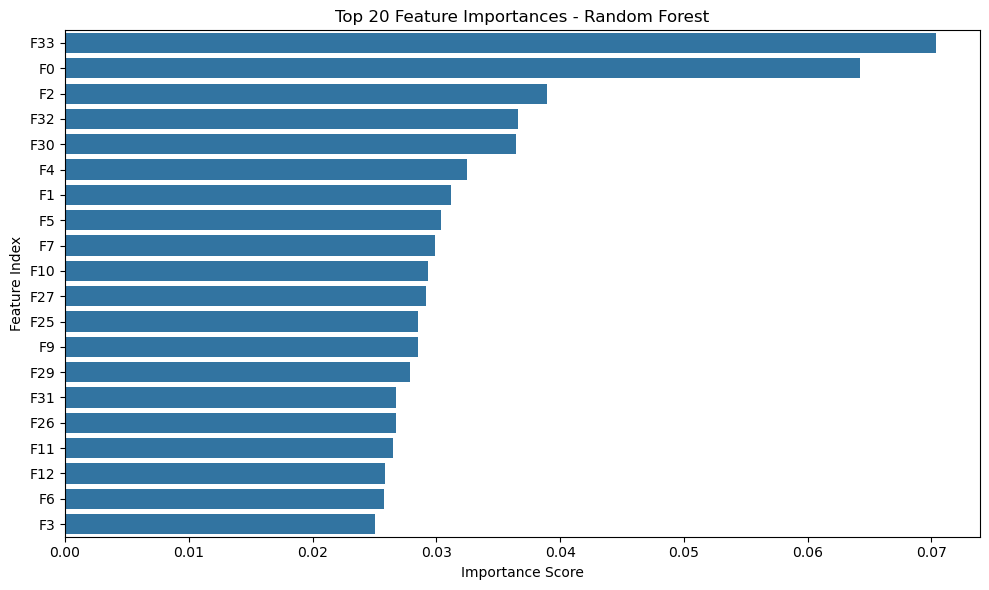

In [28]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, accuracy_score
import joblib
import os
import matplotlib.pyplot as plt
import seaborn as sns

# Create directory to store model
rf_dir = "RF"
rf_model_path = os.path.join(rf_dir, "rf_model.joblib")
os.makedirs(rf_dir, exist_ok=True)

if os.path.exists(rf_model_path):
    print("✅ Loaded saved Random Forest model.")
    rf_clf = joblib.load(rf_model_path)
else:
    print("🔍 Performing GridSearchCV to find best parameters...")

    param_grid = {
        'n_estimators': [50, 100, 200],
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5],
        'min_samples_leaf': [1, 2],
        'criterion': ['gini', 'entropy']
    }

    base_clf = RandomForestClassifier(random_state=42)
    grid_search = GridSearchCV(base_clf, param_grid, cv=3, scoring='accuracy', n_jobs=-1, verbose=1)
    grid_search.fit(X_train, y_train_encoded)

    rf_clf = grid_search.best_estimator_
    print("✅ Best Parameters:", grid_search.best_params_)
    joblib.dump(rf_clf, rf_model_path)
    print("✅ Trained and saved best Random Forest model.")

# Evaluate
y_pred_rf = rf_clf.predict(X_test)
accuracy = accuracy_score(y_test_encoded, y_pred_rf)
print(f"\nAccuracy: {accuracy * 100:.2f}%")
print("\nClassification Report:")
print(classification_report(y_test_encoded, y_pred_rf, target_names=le.classes_))

# Plot top feature importances
importances = rf_clf.feature_importances_
indices = importances.argsort()[::-1]

plt.figure(figsize=(10, 6))
sns.barplot(x=importances[indices][:20], y=[f"F{i}" for i in indices[:20]])
plt.title("Top 20 Feature Importances - Random Forest")
plt.xlabel("Importance Score")
plt.ylabel("Feature Index")
plt.tight_layout()
plt.show()

In [29]:
from sklearn.metrics import classification_report
import json

# Classification report dictionary
report = classification_report(y_test_encoded, y_pred_rf, target_names=le.classes_, output_dict=True)

# Prepare evaluation dictionary
rf_results = {
    "accuracy": accuracy * 100,
    "precision_macro": report["macro avg"]["precision"] * 100,
    "recall_macro": report["macro avg"]["recall"] * 100,
    "f1_macro": report["macro avg"]["f1-score"] * 100
}

# JSON path
json_path = "evaluation_results.json"

# Load existing results or start fresh
if os.path.exists(json_path):
    with open(json_path, "r") as f:
        all_results = json.load(f)
else:
    all_results = {}

# Add/update Random Forest results
all_results["random_forest"] = rf_results

# Save back to file
with open(json_path, "w") as f:
    json.dump(all_results, f, indent=4)

print(f"📊 Saved Random Forest evaluation under key 'random_forest' in {json_path}")


📊 Saved Random Forest evaluation under key 'random_forest' in evaluation_results.json


# **extract a 2D Mel-spectrogram**

In [20]:
# import librosa
# import numpy as np
# import os
# from tqdm import tqdm
# import matplotlib.pyplot as plt

# # Constants
# SAMPLE_RATE = 16000
# DURATION = 3  # seconds
# SAMPLES_PER_CLIP = SAMPLE_RATE * DURATION

# def preprocess_audio(file_path):
#     # Load the audio file
#     y, sr = librosa.load(file_path, sr=SAMPLE_RATE)
    
#     # Normalize the audio to have a standard amplitude
#     y = librosa.util.normalize(y)

#     # Pad or truncate the audio to the fixed length
#     if len(y) < SAMPLES_PER_CLIP:
#         y = np.pad(y, (0, SAMPLES_PER_CLIP - len(y)))
#     else:
#         y = y[:SAMPLES_PER_CLIP]
        
#     return y

# def extract_mel_spectrogram(y):
#     # Convert the audio to a Mel-spectrogram
#     mel_spec = librosa.feature.melspectrogram(y=y, sr=SAMPLE_RATE, n_mels=128)  # Correct argument is n_mels
#     mel_spec = librosa.power_to_db(mel_spec, ref=np.max)  # Convert to dB scale
#     return mel_spec


# # Apply preprocessing to all audio files
# audio_data = []
# labels = []

# for i in tqdm(range(len(df))):
#     file_path = df.loc[i, "file"]
#     emotion = df.loc[i, "emotion"]
#     try:
#         audio = preprocess_audio(file_path)
#         mel_spectrogram = extract_mel_spectrogram(audio)
#         audio_data.append(mel_spectrogram)
#         labels.append(emotion)
#     except Exception as e:
#         print(f"Error processing {file_path}: {e}")

# # Convert lists to numpy arrays
# X = np.array(audio_data)
# y = np.array(labels)

In [21]:
# print("Shape of X[0]:", X[0].shape)


In [22]:
# # Plot a sample Mel-spectrogram
# plt.figure(figsize=(10, 6))
# librosa.display.specshow(X[0], x_axis='time', y_axis='mel', sr=SAMPLE_RATE)
# plt.colorbar(format='%+2.0f dB')
# plt.title(f'Mel-Spectrogram - Sample Audio: {labels[0]}')
# plt.show()

In [23]:
# from sklearn.preprocessing import LabelEncoder
# import librosa
# import numpy as np

# # Resize all Mel-spectrograms to the same shape (128x128) for consistency
# X_resized = np.array([librosa.util.fix_length(spec, size=128) for spec in X])  # Fix length along time axis

# # Resize to add a channel dimension (height, width, 1)
# X_resized = X_resized[..., np.newaxis]

# # Label encoding
# le = LabelEncoder()
# y_encoded = le.fit_transform(y)


# **CNN Model**

# ****

# **Train and Evaluate the Model**

# **Evaluate the Model**